Section 1 - Load & Inspect data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

train.head()

,label,text,id
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,b5e99883a83f420793048898c8a41152
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",fc069d9fc54647ab94f56ccf01851c15
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,91c992a510f94058bc4b417cbe89872b
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",9b75bafdb2d640708182ded42b08e8fd
4,Inland,Estland sieht den künftigen österreichischen P...,05cf5e5ccb3f4ba69987caa492a17aed


Section 2 - Basic Dataset Overview

In [5]:
train.info()
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9245 entries, 0 to 9244
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9245 non-null   object
 1   text    9245 non-null   object
 2   id      9245 non-null   object
dtypes: object(3)
memory usage: 216.8+ KB


,label,text,id
count,9245,9245,9245
unique,9,9244,9245
top,Panorama,Der Volltext dieses auf Agenturmeldungen basie...,8943c4f645374e72a8bfe9aac39dba99
freq,1510,2,1


In [6]:
train.isna().sum()
train['label'].value_counts()

label
Panorama         1510
Web              1509
International    1360
Wirtschaft       1270
Sport            1081
Inland            913
Etat              601
Wissenschaft      516
Kultur            485
Name: count, dtype: int64

Section 3 - Visualizing the Label Distibution

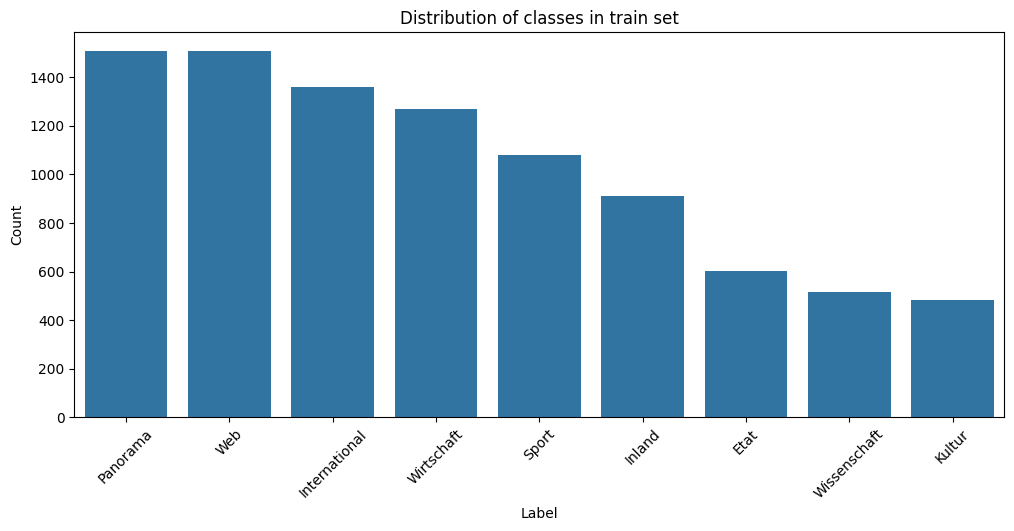

In [7]:
plt.figure(figsize=(12,5))
sns.countplot(data=train, x='label', order=train['label'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of classes in train set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Section 4 - Text Length Analysis

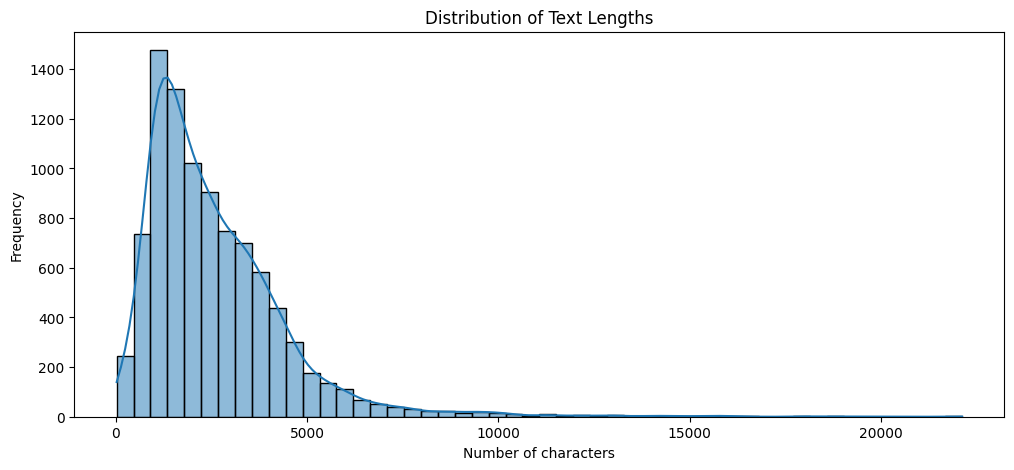

In [8]:
train['text_length'] = train['text'].str.len()

plt.figure(figsize=(12,5))
sns.histplot(train['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

Section 5 - Preprocessing

In [9]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zäöüß0-9.,!? ]", "", text)
    return text.strip()

train["text_clean"] = train["text"].apply(clean_text)
test["text_clean"]  = test["text"].apply(clean_text)

train.head()

,label,text,id,text_length,text_clean
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,b5e99883a83f420793048898c8a41152,448,21jähriger fällt wohl bis saisonende aus. wien...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",fc069d9fc54647ab94f56ccf01851c15,4020,"erfundene bilder zu filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,91c992a510f94058bc4b417cbe89872b,2116,der frischgekürte ceo sundar pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",9b75bafdb2d640708182ded42b08e8fd,664,"putin einigung, dass wir menge auf niveau von ..."
4,Inland,Estland sieht den künftigen österreichischen P...,05cf5e5ccb3f4ba69987caa492a17aed,4393,estland sieht den künftigen österreichischen p...


Model training

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_STATE = 42

Train/validation split

In [11]:
X = train["text_clean"]
y = train["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,          # 20% for validation
    random_state=RANDOM_STATE,
    stratify=y              # keep label distribution
)

X_train.shape, X_val.shape


((7396,), (1849,))

TF-IDF vectorization

In [12]:
tfidf = TfidfVectorizer(
    max_features=50000,      
    ngram_range=(1, 2),      
    min_df=3                 
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape


((7396, 50000), (1849, 50000))

MLFlow import

In [13]:
import mlflow
import mlflow.sklearn
import os

mlflow.set_tracking_uri("file:///d:/DL/HW4/mlruns")
mlflow.set_experiment("news_classification_experiment")

d:\anaconda\envs\llm2\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///d:/DL/HW4/mlruns/257553191707945299', creation_time=1765315945159, experiment_id='257553191707945299', last_update_time=1765315945159, lifecycle_stage='active', name='news_classification_experiment', tags={}>

Training Logistic Regression

In [14]:
import mlflow
import mlflow.sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

with mlflow.start_run(run_name="LogReg Baseline"):

    log_reg = LogisticRegression(max_iter=2000, n_jobs=-1)
    log_reg.fit(X_train_tfidf, y_train)

    y_pred_lr = log_reg.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_pred_lr)

    # log params
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("max_iter", 2000)

    # log metrics
    mlflow.log_metric("val_accuracy", acc)

    # save classification report
    report = classification_report(y_val, y_pred_lr)
    with open("lr_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("lr_report.txt")

    # log model
    mlflow.sklearn.log_model(log_reg, "model")

    print("LR Validation Accuracy:", acc)
    print(report)


2025/12/10 09:07:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LR Validation Accuracy: 0.8123309897241753
               precision    recall  f1-score   support

         Etat       0.97      0.56      0.71       120
       Inland       0.79      0.79      0.79       183
International       0.81      0.84      0.82       272
       Kultur       0.85      0.75      0.80        97
     Panorama       0.74      0.83      0.78       302
        Sport       0.97      0.93      0.95       216
          Web       0.85      0.88      0.87       302
   Wirtschaft       0.70      0.79      0.74       254
 Wissenschaft       0.88      0.70      0.78       103

     accuracy                           0.81      1849
    macro avg       0.84      0.78      0.80      1849
 weighted avg       0.82      0.81      0.81      1849



Linear SVM

In [15]:
from sklearn.svm import LinearSVC

with mlflow.start_run(run_name="Linear SVM"):

    svm_clf = LinearSVC()
    svm_clf.fit(X_train_tfidf, y_train)

    y_pred_svm = svm_clf.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_pred_svm)

    mlflow.log_param("model", "LinearSVM")
    mlflow.log_metric("val_accuracy", acc)

    report = classification_report(y_val, y_pred_svm)
    with open("svm_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("svm_report.txt")

    mlflow.sklearn.log_model(svm_clf, "model")

    print("SVM Validation Accuracy:", acc)
    print(report)


2025/12/10 09:07:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


SVM Validation Accuracy: 0.8361276365603029
               precision    recall  f1-score   support

         Etat       0.93      0.66      0.77       120
       Inland       0.80      0.81      0.80       183
International       0.82      0.86      0.84       272
       Kultur       0.80      0.85      0.82        97
     Panorama       0.79      0.82      0.81       302
        Sport       0.98      0.96      0.97       216
          Web       0.89      0.88      0.89       302
   Wirtschaft       0.74      0.81      0.77       254
 Wissenschaft       0.85      0.75      0.79       103

     accuracy                           0.84      1849
    macro avg       0.84      0.82      0.83      1849
 weighted avg       0.84      0.84      0.84      1849



Naive Bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB

with mlflow.start_run(run_name="Naive Bayes"):

    nb = MultinomialNB()
    nb.fit(X_train_tfidf, y_train)

    y_pred_nb = nb.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_pred_nb)

    mlflow.log_param("model", "MultinomialNB")
    mlflow.log_metric("val_accuracy", acc)

    report = classification_report(y_val, y_pred_nb)
    with open("nb_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("nb_report.txt")

    mlflow.sklearn.log_model(nb, "model")

    print("NB Validation Accuracy:", acc)
    print(report)


d:\anaconda\envs\llm2\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda\envs\llm2\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda\envs\llm2\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
2025/12/10 09:07:13 WARNING mlflow.mo

NB Validation Accuracy: 0.6717144402379664
               precision    recall  f1-score   support

         Etat       1.00      0.11      0.20       120
       Inland       0.84      0.50      0.63       183
International       0.82      0.78      0.80       272
       Kultur       0.00      0.00      0.00        97
     Panorama       0.49      0.90      0.63       302
        Sport       0.99      0.88      0.93       216
          Web       0.62      0.89      0.73       302
   Wirtschaft       0.68      0.76      0.72       254
 Wissenschaft       1.00      0.05      0.09       103

     accuracy                           0.67      1849
    macro avg       0.72      0.54      0.52      1849
 weighted avg       0.71      0.67      0.63      1849



RoBERTa

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import mlflow
import mlflow.pytorch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train["text_clean"],
    train["label"],
    test_size=0.1,
    random_state=42,
    stratify=train["label"]
)


In [38]:
MODEL_NAME = "deepset/gbert-base"
MAX_LEN = 128
EPOCHS = 10
BATCH_SIZE = 8
LR = 2e-5

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


Dataset formation

In [29]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
num_labels = len(le.classes_)

train_dataset = TextDataset(X_train, y_train_enc)
val_dataset   = TextDataset(X_val, y_val_enc)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

Loading model

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)
model.to(device)

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Total training steps
total_steps = len(train_loader) * EPOCHS

# Cosine learning rate schedule with warmup
warmup_steps = int(0.1 * total_steps)  # 10% warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# AMP scaler
scaler = GradScaler()


D:\tmp\ipykernel_21032\2042867805.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training loop

In [39]:
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

max_grad_norm = 1.0  # for gradient clipping

with mlflow.start_run(run_name="GBERT_Optimized_NoAMP"):

    # Log hyperparameters
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("max_length", MAX_LEN)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LR)
    mlflow.log_param("weight_decay", 0.01)
    mlflow.log_param("scheduler", "cosine_with_warmup")
    mlflow.log_param("use_amp", False)

    global_step = 0

    for epoch in range(EPOCHS):
        print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

        # -----------------------------
        # TRAIN
        # -----------------------------
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            # Standard FP32 forward + backward
            outputs = model(**batch)
            loss = outputs.loss

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # -----------------------------
        # VALIDATE
        # -----------------------------
        model.eval()
        total_val_loss = 0.0
        preds = []
        true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}

                outputs = model(**batch)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()

                preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels.extend(batch["labels"].cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(true_labels, preds)

        history["val_loss"].append(avg_val_loss)
        history["val_accuracy"].append(val_acc)

        # Log epoch metrics to MLflow
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss:   {avg_val_loss:.4f}")
        print(f"Val Acc:    {val_acc:.4f}")

    # Save final model
    mlflow.pytorch.log_model(model, "gbert_model_optimized")

print("\nTraining complete (optimized, no AMP).")



===== Epoch 1/10 =====
Train Loss: 0.1842
Val Loss:   0.5596
Val Acc:    0.8627

===== Epoch 2/10 =====
Train Loss: 0.1420
Val Loss:   0.6098
Val Acc:    0.8573

===== Epoch 3/10 =====
Train Loss: 0.1732
Val Loss:   0.7580
Val Acc:    0.8422

===== Epoch 4/10 =====
Train Loss: 0.1750
Val Loss:   0.8746
Val Acc:    0.8400

===== Epoch 5/10 =====
Train Loss: 0.1144
Val Loss:   0.9626
Val Acc:    0.8476

===== Epoch 6/10 =====
Train Loss: 0.0361
Val Loss:   0.9600
Val Acc:    0.8562

===== Epoch 7/10 =====
Train Loss: 0.0135
Val Loss:   0.9287
Val Acc:    0.8541

===== Epoch 8/10 =====
Train Loss: 0.0239
Val Loss:   1.0499
Val Acc:    0.8486

===== Epoch 9/10 =====
Train Loss: 0.0707
Val Loss:   1.2670
Val Acc:    0.8368

===== Epoch 10/10 =====


2025/12/10 12:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.0799
Val Loss:   1.1540
Val Acc:    0.8443


2025/12/10 12:43:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Training complete (optimized, no AMP).
